# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [26]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))


Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


# Actor Critic with PPO

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import cv2
from matplotlib.pyplot import *

In [8]:
from agent_model import * #import neural network
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [9]:
bs=128 #batch size
gradient_clip=5 #value of gradient clipping
train_length=2048 #length of the episode in frames
discount_rate=0.99
tau=0.95
ppo_iter=10 #number of reshuffling diring one training episode

# Agent

In [10]:
agent = Agent(num_inputs=state_size, num_outputs=action_size, hidden_size=64, std = nn.Parameter(torch.ones(1, action_size))) 

## Training

In [12]:
def shuffle_database(experiences): #each episode I shuffle database several times and then retrain the neural network
    """ Shuffle the global database of rollouts in place. Doesn't return anything. Requires that database exist. """
    
    states, actions, log_probs_old, returns, advantages=experiences
    
    dataset_ix = np.random.permutation(range(len(returns))) # generation of a random index permutation 

    states=states[dataset_ix]
    actions = actions[dataset_ix]
    log_probs_old = log_probs_old[dataset_ix]
    returns = returns[dataset_ix]
    advantages = advantages[dataset_ix]
    
    return [states, actions, log_probs_old, returns, advantages]

In [13]:
def train_batch(experiences):# the most important function. Here I train the neural network on a batch of samples
    """ 
    Run a single batch of data. Takes in indices, uses them to pull from global database of rollouts,
    calculates and returns losses. No gradient steps here. 
    """
    
    states, actions, log_probs_old, returns, advantages=experiences
    
    _, log_probs, values = agent(states, actions) # get the predictons
    
    critic_loss=0.5*(returns - values).pow(2).mean() # calculate critic loss
    
    
    ratio = ((log_probs - log_probs_old).exp()).squeeze(1) # calculate the ratioof the new and old probabilities 
    
    #below is the classical PPO formula implementation with the truncated ratio
    actor_loss = -torch.min(ratio * advantages, ratio.clamp(0.8, 1.2) * advantages).mean(0) 
    
    optimizier.zero_grad()
    (actor_loss + critic_loss).backward() #total loss backpropagation
    nn.utils.clip_grad_norm_(agent.parameters(), gradient_clip) #gradient clipping for training stabilization
    optimizier.step()
    

In [14]:
def reflect(experiences):# here I divide the episode experiences into batches and call train_batch function
    """ Learn from current database of rollouts for a single epoch """
    
    states, actions, log_probs_old, returns, advantages=experiences
    
    ix = 0
    while ix+bs < len(returns):
        
        batch_ix = range(ix,ix+bs)# new batch indexes 
        ix += bs
        
        states_ix, actions_ix, log_probs_old_ix, returns_ix, advantages_ix=states[batch_ix], actions[batch_ix], log_probs_old[batch_ix], returns[batch_ix], advantages[batch_ix]

        train_batch([states_ix, actions_ix, log_probs_old_ix, returns_ix, advantages_ix]) # training

In [15]:
def convert_to_masks(x): #convertation from bool to int and substraction of 1
    return [1-[0,1][i] for i in x]

In [16]:
convert_to_masks([True,False]) # here is the example

[0, 1]

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

optimizier = optim.Adam(agent.parameters(),lr=3e-4, eps=1e-5) #optimizer

def train(): #train function
        
    env_info = env.reset(train_mode=True)[brain_name]    #reset the environment
    
    episode_states=[]
    episode_values=[]
    episode_actions=[]
    episode_log_probs=[]
    episode_rewards=[]
    episode_masks=[]
    
    
    states = env_info.vector_observations  #get the first observations

    for _ in range(train_length):
        states = torch.FloatTensor(states)
        
        actions, log_probs, values = agent(states) #get the network predictions 
        env_info = env.step(actions.detach().numpy())[brain_name] #act
        next_states = env_info.vector_observations #get the new states
        rewards = torch.Tensor(env_info.rewards) #get the rewards
        masks = torch.Tensor(convert_to_masks(env_info.local_done)) #calculate the masks = 1 - dones

        #store the episode
        episode_states.append(states)
        episode_values.append(values)
        episode_actions.append(actions)
        episode_log_probs.append(log_probs)
        episode_rewards.append(rewards)
        episode_masks.append(masks)
        
    
        states = next_states #update states

    states = torch.FloatTensor(states)
    
    advantages = torch.Tensor([0]*num_agents) #advantage vector
    returns=torch.FloatTensor([0]*num_agents) #return verctor
    episode_advantages=[advantages]*(len(episode_states)) #advantages accumulated during the episode
    episode_returns=[advantages]*(len(episode_states)) #returns accumulated diring the episode
    
    #calculating advatages using GAE formula going backwards
    
    for i in range(len(episode_states) - 1,-1,-1):
        
        returns = episode_rewards[i] + discount_rate * episode_masks[i] * returns
        episode_returns[i]=returns
        
        values=episode_values[i].squeeze(1)
        
        if i==len(episode_states) - 1:
            td_error = episode_rewards[i] - values
        else:
            next_values=episode_values[i + 1].squeeze(1)
            td_error = episode_rewards[i] + discount_rate * episode_masks[i] * next_values - values
        
        advantages = tau * discount_rate * advantages * episode_masks[i] + td_error

        episode_advantages[i]=advantages
        
    #combine episode experiences in one pool
    
    episode_states = torch.cat(episode_states)
    episode_values = torch.cat(episode_values).detach()
    episode_actions = torch.cat(episode_actions)
    episode_log_probs = torch.cat(episode_log_probs).detach()
    
    episode_returns = torch.cat(episode_returns).detach()
    episode_advantages = torch.cat(episode_advantages).detach()
    
    #advantage normalization
    episode_advantages = (episode_advantages - episode_advantages.mean()) / (episode_advantages.std()+1e-8)

    for _ in range(ppo_iter):
        #shuffling the database
        episode_states, episode_actions, episode_log_probs, episode_returns, episode_advantages=shuffle_database([episode_states, episode_actions, episode_log_probs, episode_returns, episode_advantages])
        #training
        reflect([episode_states, episode_actions, episode_log_probs, episode_returns, episode_advantages])
      

In [18]:
def get_score(mode): #play an episode and calculate the score
    env_info = env.reset(train_mode=mode)[brain_name]   #reset the environment 
    states = env_info.vector_observations  #get states       
    scores = np.zeros(num_agents)       
    
    while True:
        states = torch.FloatTensor(states)
        actions, _, _=agent(states) #get the network prediction
        
        env_info = env.step(actions.cpu().detach().numpy())[brain_name] #update environment
        next_states = env_info.vector_observations  #get new state
        rewards = env_info.rewards     #get rewards                    
        dones = env_info.local_done    #get dones                 
        scores += env_info.rewards     #accumulate rewards                
        states = next_states           #update states                    
        if np.any(dones):     #play until one of the agents is done                             
            break
    
    return max(np.mean(scores[0]),np.mean(scores[1])) #return the score

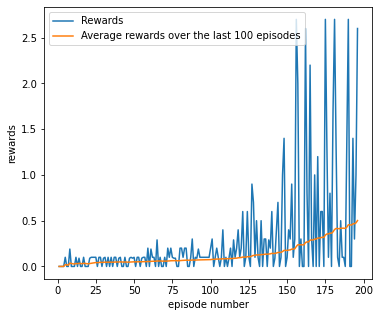

Game is solved after 196 episodes


In [19]:
n_rounds=2000

scores = [] 
test_rewards=[]
av_rewards=[]

for i in range(n_rounds):
    
    train() #train an agent
    
    new_reward=get_score(True) #play an episode and get the score
    test_rewards.append(new_reward) #accumulate test rewards
    
    start=max(0,i-99)
    av_rewards.append(np.array(test_rewards[start:i+1]).mean()) #average rewards over the last 100 episodes
    
    #plot the rewards and the average rewards 
    
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    
    
    plt.plot(range(1,i+2), test_rewards, label='Rewards')
    plt.plot(range(1,i+2), av_rewards, label='Average rewards over the last 100 episodes')
    
    plt.xlabel('episode number')
    plt.ylabel('rewards')
    
    
    plt.legend()
    plt.show()
    
    torch.save(agent.state_dict(), 'model.pth')
    
    if av_rewards[i]>0.5:
        print('Game is solved after {} episodes'.format(i+1))
        break
        
        

## Test agent

In [24]:
for _ in range(4):
    get_score(False)

In [21]:
env.close()